# Main script for nuclei segmentation

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

from config import Config
import utils
import model as modellib
import visualize
from model import log
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# pre-trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of nuclei data
DATA_DIR = os.path.join(ROOT_DIR, "data")
TRAIN_DATA_PATH = os.path.join(DATA_DIR,"stage1_train")
TEST_DATA_PATH = os.path.join(DATA_DIR,"stage1_test")

import tensorflow as tf
config_tf = tf.ConfigProto()
config_tf.gpu_options.allow_growth = True
session=tf.Session(config=config_tf)

Using TensorFlow backend.


### configuration

In [2]:
class TrainingConfig(Config):
    """Configuration for training
    Derives from the base Config class and overrides values specific
    to nulcei segmentation task
    """
    # Give the configuration a recognizable name
    NAME = "nuclei_train"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Uncomment to train on 2 GPUs (default is 1)
    GPU_COUNT = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # only nuclei and bg

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1408
    
    VALIDATION_STEPS = 5
    
    STEPS_PER_EPOCH = 100
    
    MAX_GT_INSTANCES = 400

config = TrainingConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[352 352]
 [176 176]
 [ 88  88]
 [ 44  44]
 [ 22  22]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      2
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1408
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1408 1408    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               400
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei_train
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS

### load data

In [3]:
class NucleiDataset(utils.Dataset):
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        elif image.shape[2]==4:
            image = image[:,:,:3]
        return image

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of an
        array of binary masks of shape [height, width, instances].

        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        
        mask_dir = os.path.dirname(self.image_info[image_id]['path']).replace('images','masks')
        mask_files = next(os.walk(mask_dir))[2]
        num_inst = len(mask_files)
        
        # get the shape of the image
        mask0 = skimage.io.imread(os.path.join(mask_dir,mask_files[0]))
        
        class_ids = np.ones(len(mask_files), np.int32)
        
        mask = np.zeros([mask0.shape[0],mask0.shape[1],num_inst])
        for k in range(num_inst):
            mask[:,:,k] = skimage.io.imread(os.path.join(mask_dir,mask_files[k]))
        return mask, class_ids

In [4]:
train_ids = next(os.walk(TRAIN_DATA_PATH))[1]

train_ids, val_ids = train_test_split(train_ids,train_size=0.792, random_state=1234)

test_ids = next(os.walk(TEST_DATA_PATH))[1]

dataset_train = NucleiDataset()
dataset_train.add_class("cell",1,"nulcei")
for k, train_id in enumerate(train_ids):
    dataset_train.add_image("cell",k,os.path.join(TRAIN_DATA_PATH,train_id,'images',train_id+'.png'))
dataset_train.prepare()
    
dataset_val = NucleiDataset()
dataset_val.add_class("cell",1,"nulcei")
for k, val_id in enumerate(val_ids):
    dataset_val.add_image("cell",k,os.path.join(TRAIN_DATA_PATH,val_id,'images',val_id+'.png'))
dataset_val.prepare()

dataset_test = NucleiDataset()
dataset_test.add_class("cell",1,"nulcei")
for k, test_id in enumerate(test_ids):
    dataset_test.add_image("cell",k,os.path.join(TEST_DATA_PATH,test_id,'images',test_id+'.png'))
dataset_test.prepare()


529 139
(256, 256, 3)


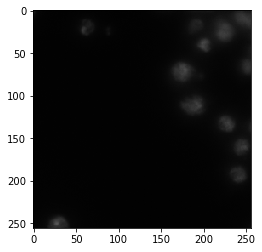

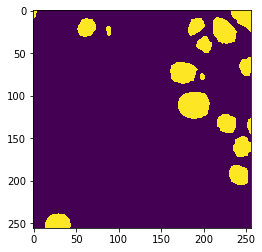

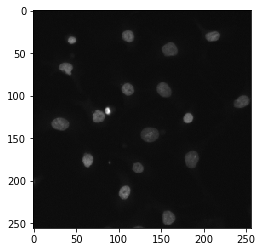

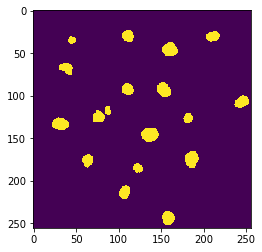

In [5]:
print len(train_ids),len(val_ids)
img = dataset_train.load_image(0)
print img.shape
plt.figure()
plt.imshow(img)
masks,class_ids = dataset_train.load_mask(0)
plt.figure()
plt.imshow(np.sum(masks,axis=2))

img = dataset_val.load_image(0)
plt.figure()
plt.imshow(img)
masks,class_ids = dataset_val.load_mask(0)
plt.figure()
plt.imshow(np.sum(masks,axis=2))

### Create Model and Load Pre-trained Weights

In [6]:
# Create model object in training mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

### Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [7]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jieyang/code/TOOK18/nuclei_maskrcnn/logs/nuclei_train20180122T2246/mask_rcnn_nuclei_train_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
('In model: ', 'rpn_model')
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_c

/home/jieyang/miniconda2/envs/keras2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jieyang/miniconda2/envs/keras2/lib/python2.7/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 408s 4s/step - loss: 1.6638 - rpn_class_loss: 0.1331 - rpn_bbox_loss: 0.5272 - mrcnn_class_loss: 0.3089 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.3145 - val_loss: 0.8655 - val_rpn_class_loss: 0.0283 - val_rpn_bbox_loss: 0.3800 - val_mrcnn_class_loss: 0.1588 - val_mrcnn_bbox_loss: 0.1141 - val_mrcnn_mask_loss: 0.1842


In [8]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/jieyang/code/TOOK18/nuclei_maskrcnn/logs/nuclei_train20180122T2246/mask_rcnn_nuclei_train_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bra

Epoch 2/2
100/100 [==============================] - 444s 4s/step - loss: 1.1065 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.2415 - val_loss: 1.0896 - val_rpn_class_loss: 0.0224 - val_rpn_bbox_loss: 0.4844 - val_mrcnn_class_loss: 0.1482 - val_mrcnn_bbox_loss: 0.1942 - val_mrcnn_mask_loss: 0.2404


### Inference

In [6]:
class InferenceConfig(TrainingConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

('Loading weights from ', '/home/jieyang/code/TOOK18/nuclei_maskrcnn/logs/nuclei_train20180122T2246/mask_rcnn_nuclei_train_0002.h5')


original_image           shape: (1408, 1408, 3)       min:    0.00000  max:  172.00000
image_meta               shape: (10,)                 min:    1.00000  max:  832.00000
gt_class_id              shape: (29,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (29, 4)               min:  576.00000  max:  832.00000
gt_mask                  shape: (1408, 1408, 29)      min:    0.00000  max:  255.00000


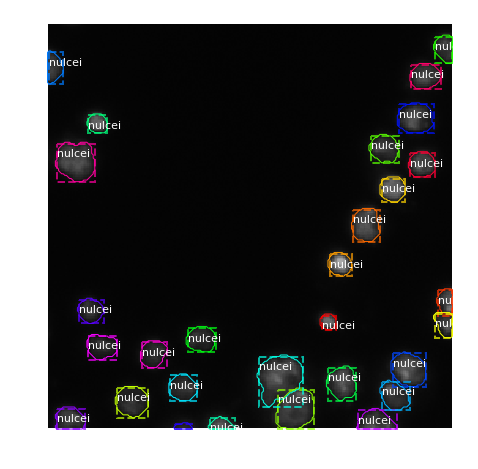

In [11]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 1
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
original_image_nr, image_meta_nr, _, gt_bbox_nr, gt_mask_nr =\
    modellib.load_image_gt_noresize(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image_nr, gt_bbox_nr, gt_mask_nr, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  172.00000
molded_images            shape: (1, 1408, 1408, 3)    min: -123.70000  max:   68.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  832.00000


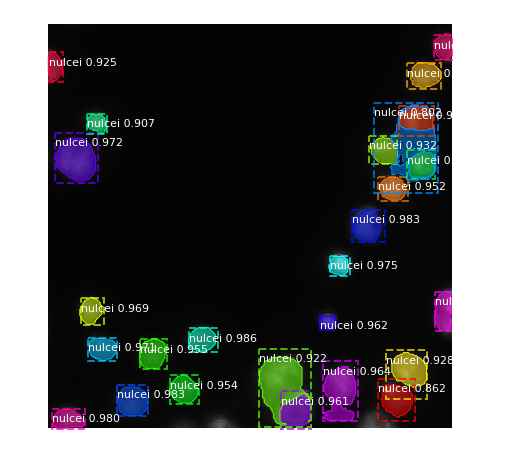

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = model.detect([original_image_nr], verbose=1)

r = results[0]
visualize.display_instances(original_image_nr, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# print dataset_val.image_info[image_id]['path']
# img = np.sum(r['masks'],axis=2)
# skimage.io.imsave('d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51_test.png',img*127)

In [12]:
import numpy as np
import utils
rmasks = r['masks']
# np.save('tmp.npy',rmasks)
# rmasks = np.load('tmp.npy')
img = np.sum(rmasks,axis=2)
print np.argwhere(img==1).shape,np.argwhere(img>1).shape
rmasks2 = utils.deoverlap_masks(rmasks)
img2 = np.sum(rmasks2,axis=2)
print np.argwhere(img2==1).shape,np.argwhere(img2>1).shape

(7112, 2) (0, 2)
(7112, 2) (0, 2)


### Evaluation

In [ ]:
# # Compute VOC-Style mAP @ IoU=0.5
# image_ids = np.random.choice(dataset_val.image_ids, len(dataset_val.image_ids))
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =\
#         utils.compute_ap(gt_bbox, gt_class_id,
#                          r["rois"], r["class_ids"], r["scores"])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))

In [ ]:
# evaluate masks
# image_ids = np.random.choice(dataset_val.image_ids, len(dataset_val.image_ids))
APs = []
for image_id in dataset_val.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt_noresize(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP = utils.sweep_iou_mask_ap(gt_mask, r["masks"], r["scores"])
    # print r["scores"]
    APs.append(AP)
    print np.mean(APs)
    
print("mAP: ", np.mean(APs))

### Test

In [77]:
# Run-length encoding from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    yield rle_encoding(x > cutoff)
    
def rle_decoding(rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    starts = np.array(rle[::2])
    lengths = np.array(rle[1::2])
    print starts
    print lengths
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape,order='F')

In [81]:
new_test_ids = []
rles = []

for image_id in dataset_test.image_ids:
    print image_id
    results = model.detect([dataset_test.load_image(image_id)], verbose=0)
    r = results[0]
    for i in range(r['masks'].shape[2]):
        rle = list(prob_to_rles(r['masks'][:,:,i]))
        rles.extend(rle)
        new_test_ids.append(dataset_test.image_info[image_id]['path'].split('/')[-1][:-4] )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


[254469 254980 255491 256003 256514 257026 257537 258049 258561 259073
 259585 260097 260609 261121 261634 262146 262658 263170 263682 264194
 264706 265219 265731 266243 266755 267267 267780 268292 268805 269317
 269830 270344 270858 271371 271885 272398 272911 273424 273939 274454
 274970 275484 276012]
[13 15 20 24 29 31 34 36 38 39 40 42 43 45 47 49 50 52 53 53 54 54 54 55 55
 56 55 56 56 56 55 53 51 50 48 47 46 45 40 35 31 28  2]


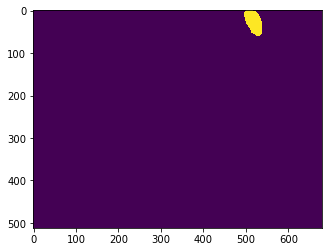

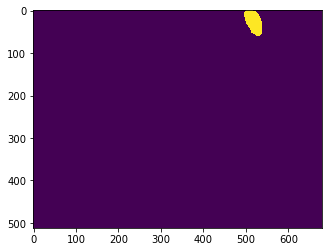

In [82]:
rle = list(prob_to_rles(r['masks'][:,:,0]))
img = rle_decoding(rle[0], r['masks'][:,:,0].shape)
plt.imshow(img)
plt.figure()
plt.imshow(r['masks'][:,:,0])

In [83]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-test-1.csv', index=False)